# GreenValueNet

This notebook contains the code needed to execute the GreenValueNet hedonic pricing neural network. 

### Set up and data loading

In [1]:
import joblib
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from data_load_funcs import get_params, load_data_catalogue
from processing_funcs import process_data, normalise_arr
from model_funcs import *

cwd = Path.cwd()
params = get_params()
data_catalogue = load_data_catalogue()

The `dataset.csv` file from `data/interim_files` is loaded if it already exists, or constructed if not. To build the dataset please follow the steps in [Annex 1 of the ReadMe file](readme.md#annex-1) to esnure all relevant files have been downloaded. 

In [2]:
dataset = process_data(data_catalogue, params)

# show summary stats
summary_stats = dataset.describe().transpose()[['mean', 'std', 'max', 'min']]
summary_stats.columns = ['Mean', 'Std Dev', 'Maximum', 'Minimum']
print(summary_stats)

Processed dataset already exists.
Loading exisitng dataset...
                                  Mean    Std Dev       Maximum   Minimum
ln_price                     12.393713   0.658136     18.134158  0.116855
propertytype                  1.328094   1.085676      3.000000  0.000000
oldnew                        0.134435   0.341119      1.000000  0.000000
duration                      0.325202   0.468482      2.000000  0.000000
current_energy_efficiency    61.056443  12.444568    347.000000  0.000000
potential_energy_efficiency   0.805024   0.140106      1.000000  0.000000
total_floor_area             91.622326  68.669650  60506.700000  0.000000
extension_count               0.495053   0.743755      4.000000  0.000000
number_habitable_rooms        4.521529   1.748808    100.000000  0.000000
number_heated_rooms           4.437662   1.754007    100.000000  0.000000
construction_age_band         4.477500   3.153767     10.000000 -1.000000
coastline_dist               57.173176  38.518186 

In [3]:
print(dataset.shape)
print(dataset.isnull().sum())

(12909200, 26)
transactionid                  0
ln_price                       0
postcode                       0
propertytype                   0
oldnew                         0
duration                       0
current_energy_efficiency      0
potential_energy_efficiency    0
total_floor_area               0
extension_count                0
number_habitable_rooms         0
number_heated_rooms            0
construction_age_band          0
coastline_dist                 0
prim_school_dist               0
sec_school_dist                0
roads_dist                     0
nat_park_dist                  0
nat_trust_dist                 0
ttwa_dist                      0
dom_builds_share               0
garden_share                   0
non_dom_builds_share           0
path_share                     0
greenspace_share               0
water_share                    0
dtype: int64


Now we normalise any non-encoded variables to make the loss function more symmetrics, and therefore increase speed of learning of algorithm and convert the dataset to an array of inputs, and an associated output array.

In [4]:
# creates in input array of shape m,x and an output array of shape m
x, y, derivative_index, norm_index = create_x_y_arr(dataset, params)

x_norm, pop_mean, pop_std = normalise_arr(x, norm_index)

The dataset is then split into train, dev and test sets using sci-kit learn.

In [5]:
x_train, x_dev, x_test, y_train, y_dev, y_test = split_to_test_dev_train(
    x_norm,
    y,
    params['dev_size'],
    params['test_size'],
    prop=False
)

## Benchmarking

To evaluate the performance of my neural network we use random forest and XGBoost regressions as baseline models. We optimise based on the mean squared error (MSE) and report this as our measure of performance.

### Random Forest


In [6]:
# run baseline random forest regression using scikit-learn
rf_hp_space = params['tuning_dict']['rf_space']
rfr_model = baseline_model(
    x_train,
    y_train,
    RandomForestRegressor,
    tuning=False,
    tuning_params=rf_hp_space,
    tuning_iter=params['tuning_dict']['n_iter']
)

# generate predictions and measure according to mean squared error
rfr_pred, rfr_mse = generate_pred_metric(rfr_model, mean_squared_error, x_dev, y_dev)

### XGBoost

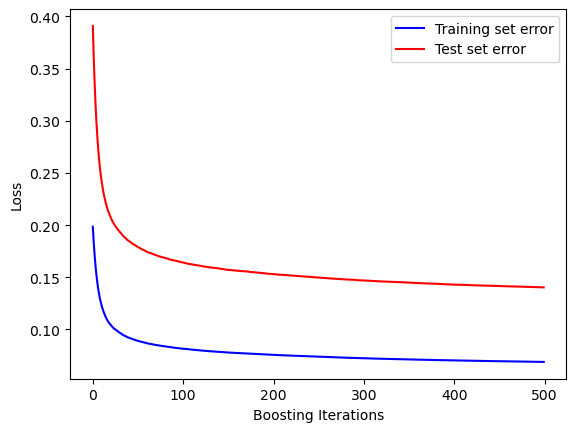

In [ ]:
# run baseline gradient boosting regression using scikit-learn
xg_hp_space = params['tuning_dict']['xg_space']
xgb_model = baseline_model(
    x_train,
    y_train,
    HistGradientBoostingRegressor,
    tuning=False,
    tuning_params=xg_hp_space,
    tuning_iter=params['tuning_dict']['n_iter'],
    max_iter = 500,
    max_depth = 18,
    learning_rate = 0.1,
    min_samples_leaf=50
)

# generate predictions and measure according to mean squared error
xgb_pred, xgb_mse = generate_pred_metric(xgb_model, mean_squared_error, x_dev, y_dev)

# plot loss over iterations
plot_loss(xgb_model, validation_data=(x_dev, y_dev), metric=mean_squared_error)

## Neural networks

We know build some neural networks. Number of epochs, hidden layers, and nodes in hidden layers is initially set with rules of thumb but then optimiszed using hyperparameter tuning.

In [6]:
# set epochs based on past convergence behaviour
epochs = 25

# set n_hidden_units to be mean of input and output layer sizes
n_hidden_units = round((x_train.shape[1] + 1) / 2)

### Single Layer Neural Network

A single hidden layer with ReLU activation is used with a linear output layer.

In [7]:
tune_nn = False
single_nn = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 1,
    tuning = tune_nn,
)
single_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                288       
                                                                 
 batch_normalization (Batch  (None, 12)                48        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 349 (1.36 KB)
Trainable params: 325 (1.27 KB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [8]:
single_nn.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_data = (x_dev, y_dev),
    callbacks=[get_checkpoint('single_nn')]
)

Epoch 1/25
201394/201394 [==============================] - 72s 354us/step - loss: 0.2532 - mse: 0.2532 - val_loss: 0.1949 - val_mse: 0.1949
Epoch 2/25
201394/201394 [==============================] - 72s 356us/step - loss: 0.2080 - mse: 0.2080 - val_loss: 0.1959 - val_mse: 0.1959
Epoch 3/25
201394/201394 [==============================] - 71s 351us/step - loss: 0.2058 - mse: 0.2058 - val_loss: 0.1939 - val_mse: 0.1939
Epoch 4/25
201394/201394 [==============================] - 71s 350us/step - loss: 0.2046 - mse: 0.2046 - val_loss: 0.1964 - val_mse: 0.1964
Epoch 5/25
201394/201394 [==============================] - 71s 350us/step - loss: 0.2044 - mse: 0.2044 - val_loss: 0.1962 - val_mse: 0.1962
Epoch 6/25
201394/201394 [==============================] - 70s 349us/step - loss: 0.2043 - mse: 0.2043 - val_loss: 0.1986 - val_mse: 0.1986
Epoch 7/25
201394/201394 [==============================] - 70s 347us/step - loss: 0.2042 - mse: 0.2042 - val_loss: 0.2039 - val_mse: 0.2039
Epoch 8/25
20

### Deep Neural Network

The full model is specified as a deep neural network using layers with ReLU activation functions with a linear activation in the output layer. The choice of number of layers was initially kept small due to computational processing constraints.

In [9]:
tune_nn = False

deep_nn = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 10,
    tuning = tune_nn,
    learning_rate=0.1
)

deep_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12)                288       
                                                                 
 batch_normalization_1 (Bat  (None, 12)                48        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 batch_normalization_2 (Bat  (None, 12)                48        
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 12)               

In [10]:
deep_nn.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_data = (x_dev, y_dev),
    callbacks=[get_checkpoint('deep_nn')]
)

Epoch 1/25
201394/201394 [==============================] - 197s 971us/step - loss: 0.2164 - mse: 0.2164 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 2/25
201394/201394 [==============================] - 194s 964us/step - loss: 0.2075 - mse: 0.2075 - val_loss: 0.2080 - val_mse: 0.2080
Epoch 3/25
201394/201394 [==============================] - 194s 966us/step - loss: 0.2077 - mse: 0.2077 - val_loss: 0.2050 - val_mse: 0.2050
Epoch 4/25
201394/201394 [==============================] - 194s 964us/step - loss: 0.2070 - mse: 0.2070 - val_loss: 17.1965 - val_mse: 17.1965
Epoch 5/25
201394/201394 [==============================] - 196s 973us/step - loss: 0.2078 - mse: 0.2078 - val_loss: 0.3272 - val_mse: 0.3272
Epoch 6/25
201394/201394 [==============================] - 196s 973us/step - loss: 0.2067 - mse: 0.2067 - val_loss: 0.1977 - val_mse: 0.1977
Epoch 7/25
201394/201394 [==============================] - 195s 966us/step - loss: 0.2070 - mse: 0.2070 - val_loss: 0.1883 - val_mse: 0.1883
Epoc

### Hyperparameter tuning

We know run the deep neural network but rather than setting the learning rate, hidden units and hidden layers ourself we let the model determine the optimal set of hyperparameters using Bayesian updating of the hyperparameters.

In [13]:
tune_nn = True

deep_nn_t = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 10,
    tuning = tune_nn,
    dropout=True,
    d_rate = 0.1
)

if tune_nn:
    tuner = run_hp_search(
        x_train,
        y_train,
        validation_set=(x_dev, y_dev),
        search_name='neural_net_240902'
    )
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(best_hps.values)
    deep_nn_t = tuner.hypermodel.build(best_hps)

deep_nn_t.summary()

Trial 20 Complete [00h 40m 18s]
mse: 0.15121331810951233

Best mse So Far: 0.1499028205871582
Total elapsed time: 12h 20m 15s
{'n_units': 144, 'n_layers': 8, 'lr': 0.001}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 144)               3456      
                                                                 
 batch_normalization_8 (Bat  (None, 144)               576       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 144)               0         
                                                                 
 dense_10 (Dense)            (None, 144)               20880     
                                                                 
 batch_normalization_9 (Bat  (None, 144)               576       
 chNormalizatio

In [14]:
if tune_nn:
    deep_nn_t.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=64,
        validation_data = (x_dev, y_dev),
        callbacks=[get_checkpoint('deep_nn_tuning')]
    )

Epoch 1/25
201394/201394 [==============================] - 636s 3ms/step - loss: 0.2143 - mse: 0.2143 - val_loss: 0.1481 - val_mse: 0.1481
Epoch 2/25
201394/201394 [==============================] - 534s 3ms/step - loss: 0.1499 - mse: 0.1499 - val_loss: 0.1373 - val_mse: 0.1373
Epoch 3/25
201394/201394 [==============================] - 515s 3ms/step - loss: 0.1444 - mse: 0.1444 - val_loss: 0.1351 - val_mse: 0.1351
Epoch 4/25
201394/201394 [==============================] - 579s 3ms/step - loss: 0.1411 - mse: 0.1411 - val_loss: 0.1320 - val_mse: 0.1320
Epoch 5/25
201394/201394 [==============================] - 602s 3ms/step - loss: 0.1388 - mse: 0.1388 - val_loss: 0.1299 - val_mse: 0.1299
Epoch 6/25
201394/201394 [==============================] - 595s 3ms/step - loss: 0.1371 - mse: 0.1371 - val_loss: 0.1287 - val_mse: 0.1287
Epoch 7/25
201394/201394 [==============================] - 582s 3ms/step - loss: 0.1358 - mse: 0.1358 - val_loss: 0.1298 - val_mse: 0.1298
Epoch 8/25
201394/20

## Results

In [ ]:
nn_dict = {
    'Shallow neural net': single_nn.history.history.copy(),
    'Deep neural net': deep_nn.history.history.copy(),
    'Deep neural net (tuned)': deep_nn_t.history.history.copy()
}
baseline_dict = {
    # 'Random Forest': rfr_mse,
    'XGBoost baseline': 0.1403
}

generate_plot(nn_dict, baseline_dict, cut_off_epoch=25, save=True, name='model_mse_240227.png')

![Line chart showing the declining mse of the neural network over iterations relative to the benchmark models.](outputs/images/model_mse_240226.png)

### Calculating marginal valuation of environmental attributes

Once we have a model with environmental attributes as features and log of house price as the target variable, we can begin to construct the marginal willingness to pay for environmental attributes, and therefore get a proxy for their value.

The partial derivative of `ln_price` w.r.t an input variable can be evaluated during the backwards propagation stage of the model fitting. By evaluating this derivative at a variety of samples, we can plot a valulation curve for the change in $ln(price)$ for a change in the input feature by 1 standard deviation.

Average marginal value of environmental amenities (£):
coastline_dist      1.478715
nat_park_dist       1.253770
nat_trust_dist      1.011435
greenspace_share    1.494936
water_share         1.741837
dtype: float32


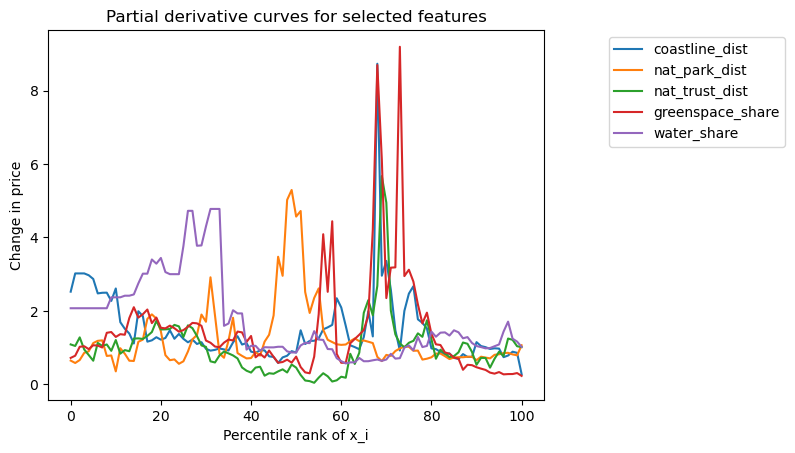

In [16]:
# extract the gradients from the model
if tune_nn:
    model_to_plot = deep_nn_t
else:
    model_to_plot = deep_nn

points_to_eval = 100
gradients, synthetic_data = calc_partial_grad(
    deep_nn_t,
    x,
    derivative_index,
    norm_index,
    pop_mean,
    pop_std,
    points_to_eval,
    clip_val = 100)

average_grad = {key: np.mean(values) for key, values in gradients.items()}
average_grad = pd.Series(average_grad)

print("Average marginal value of environmental amenities (£):")
print(average_grad)
plot_partial_grads(gradients, np.arange(points_to_eval+1), save=True, name='partial_grads_back_prop_240227.png')

Average marginal value of environmental amenities (£):
coastline_dist      1.005107
nat_park_dist       1.001165
nat_trust_dist      0.985727
greenspace_share    0.914222
water_share         1.159785
dtype: float64


/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:452: RuntimeWarning: invalid value encountered in divide
  output_diff = np.diff(predictions)
/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:453: RuntimeWarning: invalid value encountered in divide
  input_diff = np.diff(sampled_vals)


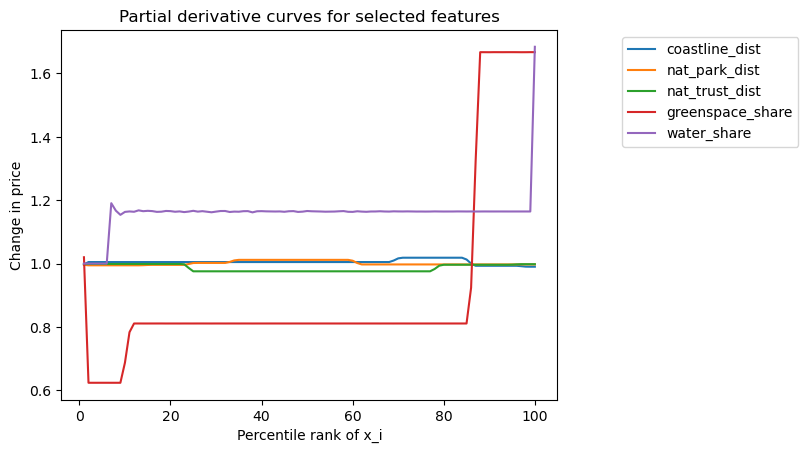

In [20]:
if tune_nn:
    model_to_plot = deep_nn_t
else:
    model_to_plot = deep_nn

gradients, synthetic_data = calc_partial_grad_linear(
    single_nn,
    x,
    derivative_index,
    norm_index,
    pop_mean,
    pop_std,
    100)

average_grad = {key: np.mean(values) for key, values in gradients.items()}
average_grad = pd.Series(average_grad)

print("Average marginal value of environmental amenities (£):")
print(average_grad)
plot_partial_grads(gradients, np.arange(100)+1, save=True, name='partial_grads_approx_240227.png')

/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:452: RuntimeWarning: invalid value encountered in divide
  output_diff = np.diff(predictions)
/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:453: RuntimeWarning: invalid value encountered in divide
  input_diff = np.diff(sampled_vals)
/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:452: RuntimeWarning: invalid value encountered in divide
  output_diff = np.diff(predictions)
/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:453: RuntimeWarning: invalid value encountered in divide
  input_diff = np.diff(sampled_vals)
/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:452: RuntimeWarning: invalid value encountered in divide
  output_diff = np.diff(predictions)
/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/model_funcs.py:453: RuntimeWarning: invalid value encountered in divide
  input_diff = np.diff(sampled_vals)
/Use

<Figure size 1200x1000 with 0 Axes>

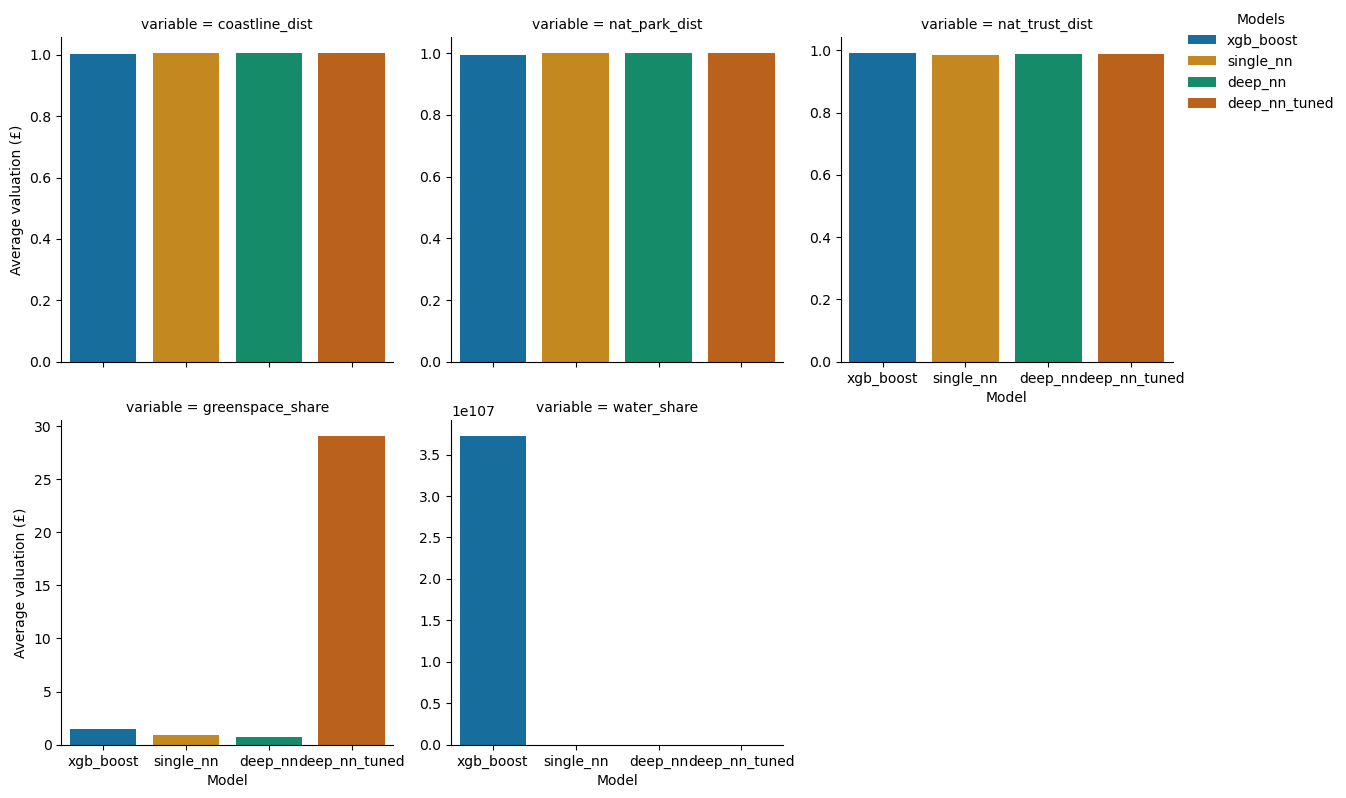

In [23]:
model_dict = {
    'xgb_boost': xgb_model,
    'single_nn': single_nn,
    'deep_nn': deep_nn,
    'deep_nn_tuned': deep_nn_t
}

avg_vals = plot_avg_val_by_model(
    model_dict,
    plot=True,
    save=True,
    name='average_val_by_model_240207.png',
    dataset = x,
    derivative_index=derivative_index,
    norm_index=norm_index,
    pop_mean=pop_mean,
    pop_std=pop_std,
    num_points_to_eval=100
)

### Saving models

Here we save the pre-trained models so they can be loaded and used.

In [19]:
model_dir = cwd / "outputs" / "models"

# save models as tensor objects
if tune_nn:
    deep_nn_t.save(model_dir / "deep_nn_tuning.keras")
deep_nn.save(model_dir / "deep_nn.keras")
    
single_nn.save(model_dir / "single_nn.keras")

# save models as joblib files
joblib.dump(xgb_model, model_dir / "xgboost.joblib")

['/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/outputs/models/xgboost.joblib']

In [22]:
# to reload models
model_dir = cwd / "outputs" / "models"
# if tune_nn:
#     deep_nn_t = tf.keras.models.load_model(model_dir / "deep_nn_tuning.keras")
# deep_nn = tf.keras.models.load_model(model_dir / "deep_nn.keras")
    
# single_nn = tf.keras.models.load_model(model_dir / "single_nn.keras")

xgb_model = joblib.load(model_dir / "xgboost.joblib")

/Users/Felix_Gallagher/miniforge3/envs/greenvalue-net/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/Felix_Gallagher/miniforge3/envs/greenvalue-net/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
